<a href="https://colab.research.google.com/github/ffrank123/-/blob/main/Clustering_Informe_Profesional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🧾 INFORME PROFESIONAL — Segmentación de Clientes (Mall Customers) con 3 Modelos de Clustering
**Autor:** fran franklin calizaya apaza
**Dataset:** `Mall_Customers.csv`  
**Variables (exactamente 3):** `Age`, `Annual Income (k$)`, `Spending Score (1-100)`

---

## Índice
1. Objetivo y criterios de evaluación  
2. Dependencias y configuración del entorno  
3. Carga de datos (control de calidad)  
4. Selección de variables y justificación  
5. EDA (Histogramas, Boxplots, Dispersión 2D/3D)  
6. Estandarización y PCA (visual)  
7. Modelo 1: K-Means (búsqueda de *k*, codo, métricas, interpretación)  
8. Modelo 2: DBSCAN (k-distance, rejilla de eps/min_samples, métricas, interpretación)  
9. Modelo 3: Agglomerative (búsqueda k+linkage, **dendrograma**, métricas, interpretación)  
10. Comparativa formal (Silhouette, DBI, CHI) y análisis de diferencias  
11. Conclusión y recomendación para negocio  
12. Limitaciones, riesgos y mejoras futuras  
13. Exportación de etiquetas para perfiles

> Este cuaderno está **altamente documentado**, con código fraccionado por pasos y comentarios detallados.



## 1) Objetivo y Criterios de Evaluación
**Objetivo:** construir una **segmentación de clientes** con tres técnicas distintas de clustering y **compararlas** técnica y operacionalmente.

**Criterios (rubrica/casillas):**
- Contexto y **justificación de variables** (por qué estas 3).
- **EDA exhaustiva** con gráficos claros (1 por figura).
- **Preparación** de datos (estandarización, PCA *visual*).
- Modelado de **K-Means** (elección de *k*, codo, métricas).
- Modelado de **DBSCAN** (k-distance, selección `eps`/`min_samples`, ruido).
- Modelado **Jerárquico** (búsqueda de `k`/`linkage`, **dendrograma**).
- **Comparativa formal** con métricas e interpretación de diferencias.
- **Conclusión** con recomendación para negocio.
- **Limitaciones** y **mejoras**.
- **Exportación** de etiquetas (para perfiles y acciones).


## 2) Dependencias y Configuración del Entorno

In [1]:

# Este bloque sólo verifica versiones y configura estilo de gráficos.
import sys, platform
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

print("Python:", sys.version.split()[0])
print("OS:", platform.system(), platform.release())
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Matplotlib:", matplotlib.__version__)

# Estilo básico para gráficos
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


Python: 3.12.12
OS: Linux 6.6.105+
NumPy: 2.0.2
Pandas: 2.2.2
Matplotlib: 3.10.0


## 3) Carga de Datos (Control de Calidad)

In [2]:

# Cargar el CSV original. Verificamos dimensiones y tipos.
CSV_PATH = "Mall_Customers.csv"
df = pd.read_csv(CSV_PATH)

print("Dimensión (filas, columnas):", df.shape)
display(df.head())
display(df.info())


Dimensión (filas, columnas): (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


None


## 4) Selección de Variables y Justificación
Usaremos exactamente **3 variables** por consigna y porque:
- Permiten **visualización 3D** directa.
- Capturan **demografía** (Age), **capacidad de compra** (Income) y **comportamiento** (Spending).
- Son suficientes para una **segmentación interpretable** de marketing.

**Variables esperadas:** `Age`, `Annual Income (k$)`, `Spending Score (1-100)`  
Si los encabezados cambian, se intenta un mapeo flexible.


In [3]:

# Selección estricta de 3 variables con mapeo flexible si fuera necesario.
FEATURES = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

cols = list(df.columns)
missing = [c for c in FEATURES if c not in cols]

if missing:
    # Mapeo por normalización (minúsculas sin espacios)
    norm_cols = {c: c.strip().lower().replace(" ", "") for c in cols}
    targets = [c.strip().lower().replace(" ", "") for c in FEATURES]
    mapping = {}
    for t, tn in zip(FEATURES, targets):
        for orig, on in norm_cols.items():
            if on == tn:
                mapping[t] = orig
                break
    if len(mapping) == len(FEATURES):
        FEATURES = [mapping[c] for c in FEATURES]
    else:
        raise ValueError(f"No se encontraron las 3 columnas esperadas. Columnas CSV: {cols}")

X = df[FEATURES].copy()

# Limpieza mínima: retirar infinitos y nulos
X = X.replace([np.inf, -np.inf], np.nan).dropna()
idx_valid = X.index  # Para mapear etiquetas a filas originales

print("✅ Variables definitivas:", FEATURES)
display(X.describe())


✅ Variables definitivas: ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']


,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


## 5) EDA — Histogramas (distribución univariada)

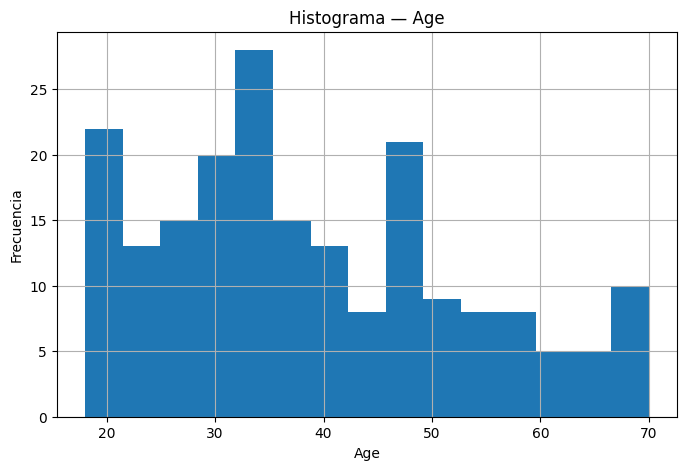

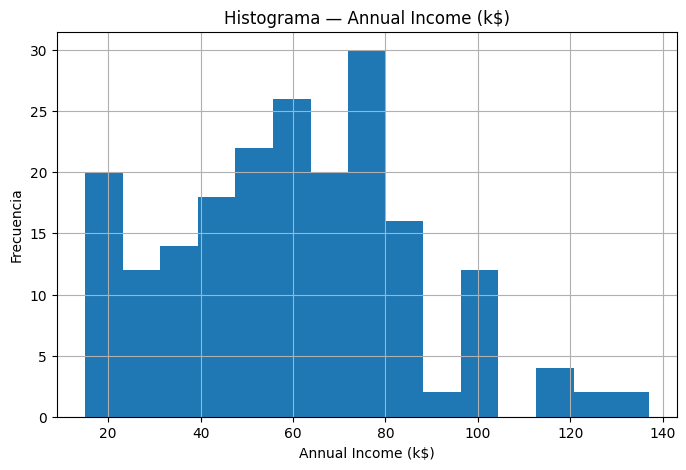

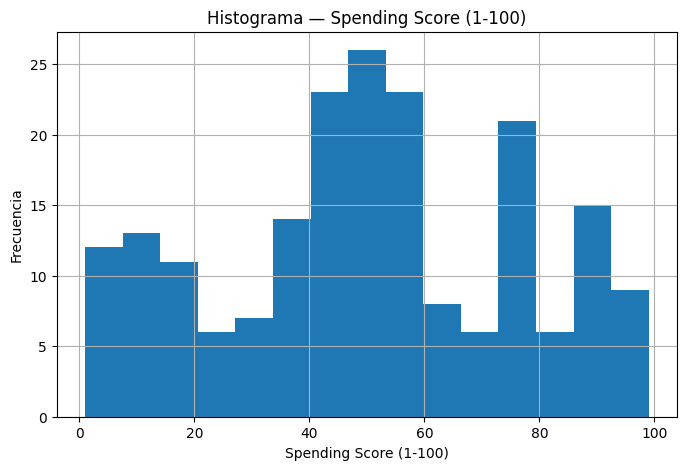

In [4]:

# Un gráfico por figura (no subplots), para claridad y mejor lectura.
for col in X.columns:
    plt.figure()
    plt.hist(X[col], bins=15)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.show()


### Boxplots (detección visual de outliers)

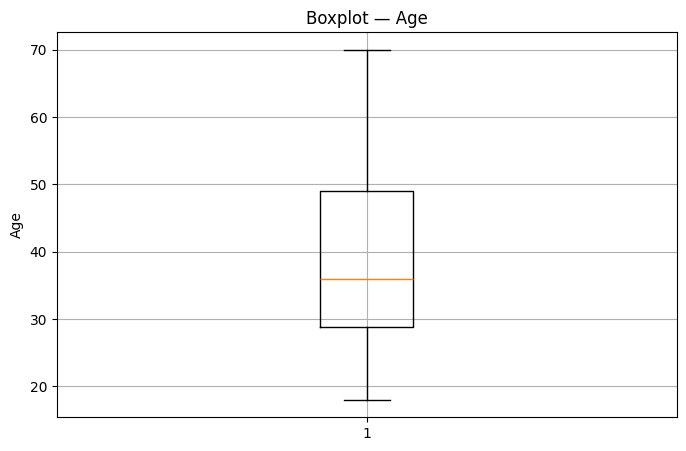

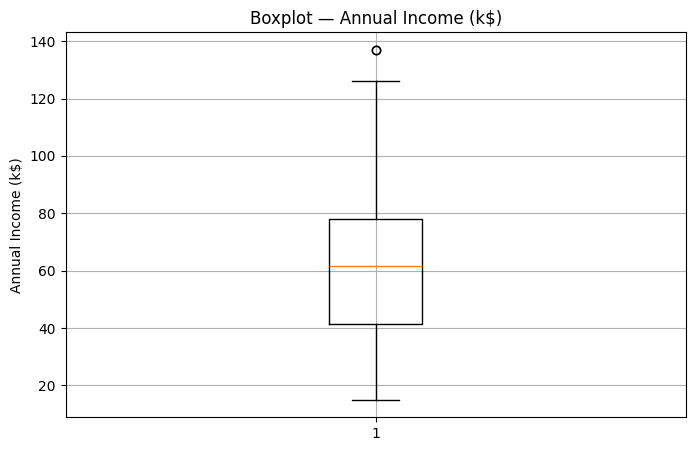

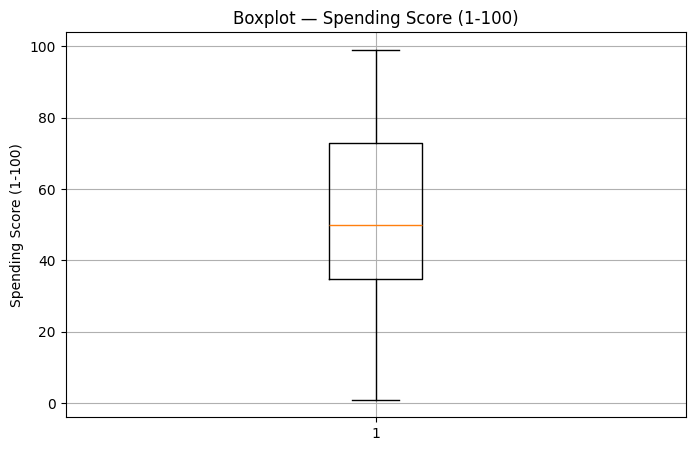

In [5]:

for col in X.columns:
    plt.figure()
    plt.boxplot(X[col].values, vert=True)
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.show()


### Dispersión 2D (relaciones bivariadas)

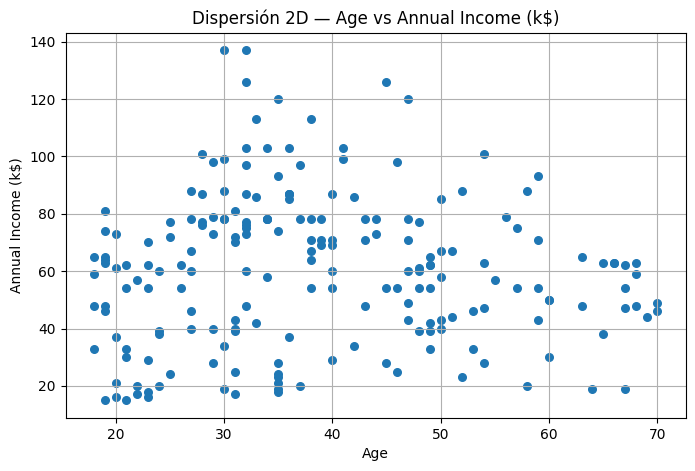

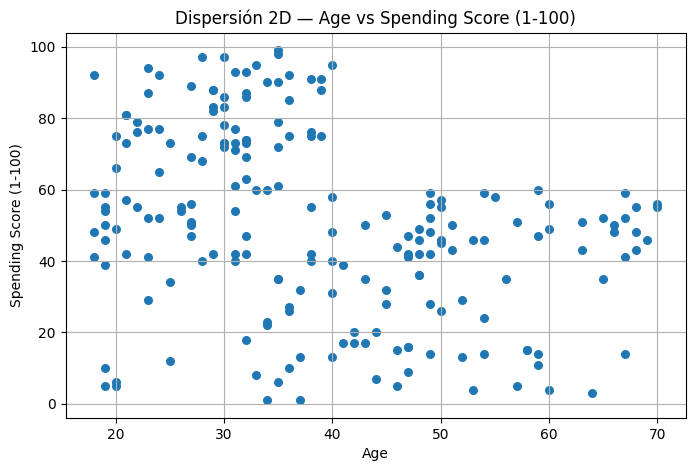

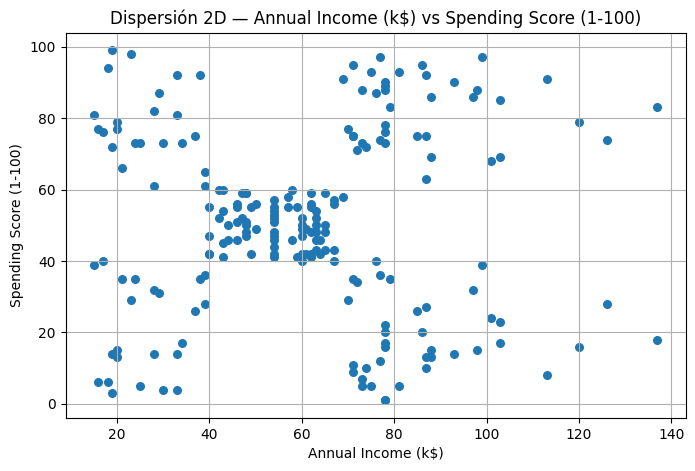

In [6]:

pairs = [(FEATURES[0], FEATURES[1]), (FEATURES[0], FEATURES[2]), (FEATURES[1], FEATURES[2])]
for a, b in pairs:
    plt.figure()
    plt.scatter(X[a], X[b], s=30)
    plt.title(f"Dispersión 2D — {a} vs {b}")
    plt.xlabel(a); plt.ylabel(b)
    plt.show()


### Dispersión 3D (visión conjunta)

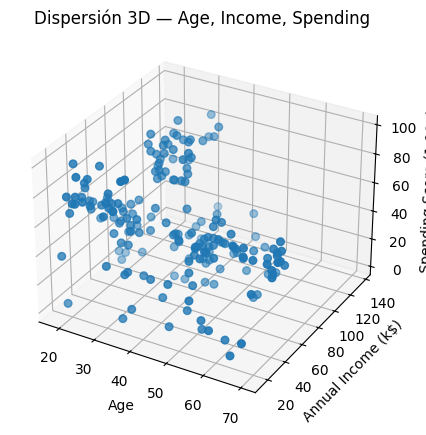

In [7]:

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[FEATURES[0]], X[FEATURES[1]], X[FEATURES[2]], s=30)
ax.set_title("Dispersión 3D — Age, Income, Spending")
ax.set_xlabel(FEATURES[0]); ax.set_ylabel(FEATURES[1]); ax.set_zlabel(FEATURES[2])
plt.show()



## 6) Estandarización y PCA (sólo visual)
**Por qué estandarizar:** los algoritmos basados en distancia son sensibles a escala; sin escalar, `Annual Income` dominaría.  
**PCA 2D:** se usa **solo para visualización**, no para el entrenamiento.


✅ Estandarización completa: media≈0, desviación≈1 (por variable).
Varianza explicada por PC1 y PC2: [0.44266167 0.33308378]


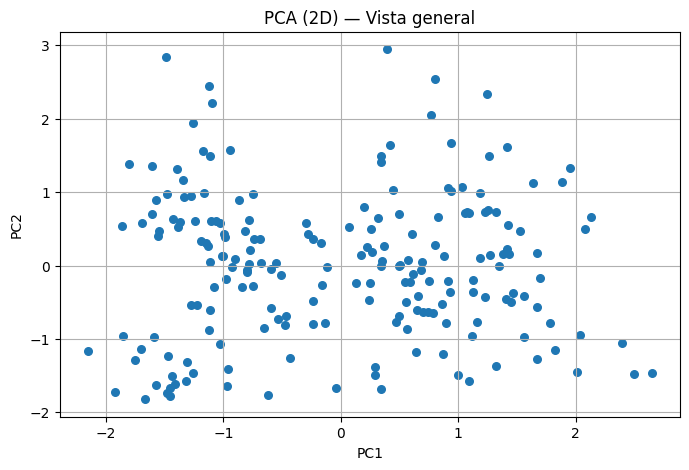

In [8]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values)

print("✅ Estandarización completa: media≈0, desviación≈1 (por variable).")

pca2 = PCA(n_components=2, random_state=42)
X_2d = pca2.fit_transform(X_scaled)
print("Varianza explicada por PC1 y PC2:", pca2.explained_variance_ratio_)

plt.figure()
plt.scatter(X_2d[:,0], X_2d[:,1], s=30)
plt.title("PCA (2D) — Vista general")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


### Funciones auxiliares (métricas y gráficos)

In [9]:

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def evaluar(labels, X_data):
    """Calcula métricas estándar para clustering sobre X_data.
    - Silhouette  (↑ mejor)
    - Davies-Bouldin (↓ mejor)
    - Calinski-Harabasz (↑ mejor)
    Maneja casos inválidos (1 cluster o todo ruido).
    """
    unique = set(labels)
    n_labels = len(unique)
    if n_labels < 2 or (n_labels == 1 and -1 in unique):
        return {'silhouette': np.nan, 'dbi': np.nan, 'chi': np.nan, 'n_clusters': n_labels}
    return {
        'silhouette': silhouette_score(X_data, labels),
        'dbi': davies_bouldin_score(X_data, labels),
        'chi': calinski_harabasz_score(X_data, labels),
        'n_clusters': n_labels
    }

def plot2d(X2d, labels, title):
    plt.figure()
    plt.scatter(X2d[:,0], X2d[:,1], c=labels, s=35)
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

def plot3d(X3d, labels, title, axes_names):
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X3d[:,0], X3d[:,1], X3d[:,2], c=labels, s=30)
    ax.set_title(title)
    ax.set_xlabel(axes_names[0]); ax.set_ylabel(axes_names[1]); ax.set_zlabel(axes_names[2])
    plt.show()



## 7) Modelo 1 — K-Means
**Idea:** particiona en *k* grupos minimizando la variación intra-cluster.  
**Clave:** elegir **k** apropiado.


### 7.1 Búsqueda de k (Silhouette y Codo)

⭐ Mejor k por Silhouette: 6 (score=0.431)


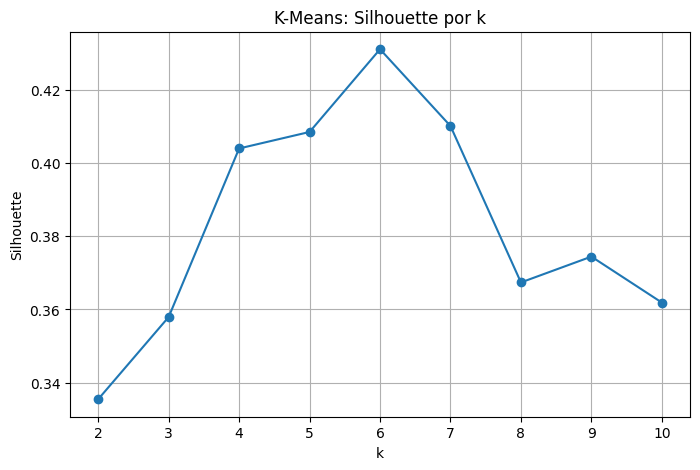

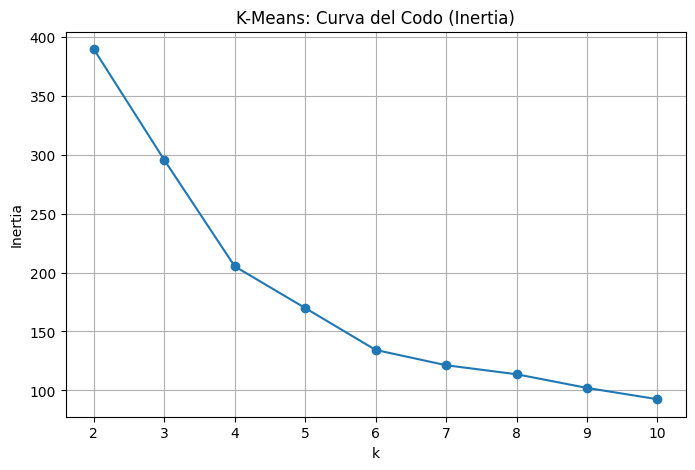

In [10]:

from sklearn.cluster import KMeans

k_range = range(2, 11)
sil_scores, inertias = [], []
mejor_k, mejor_sil = None, -1

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_scaled)
    inertias.append(km.inertia_)
    met = evaluar(km.labels_, X_scaled)
    sil_scores.append(np.nan if np.isnan(met['silhouette']) else met['silhouette'])
    if not np.isnan(met['silhouette']) and met['silhouette'] > mejor_sil:
        mejor_sil = met['silhouette']
        mejor_k = k

print(f"⭐ Mejor k por Silhouette: {mejor_k} (score={mejor_sil:.3f})")

# Curva de Silhouette por k
plt.figure()
plt.plot(list(k_range), sil_scores, marker='o')
plt.title("K-Means: Silhouette por k")
plt.xlabel("k"); plt.ylabel("Silhouette")
plt.show()

# Curva del Codo (Inertia)
plt.figure()
plt.plot(list(k_range), inertias, marker='o')
plt.title("K-Means: Curva del Codo (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")
plt.show()


### 7.2 Entrenamiento final y evaluación

📊 Métricas K-Means: {'silhouette': np.float64(0.43106526216603014), 'dbi': np.float64(0.8349663784782569), 'chi': np.float64(134.47517082663606), 'n_clusters': 6}


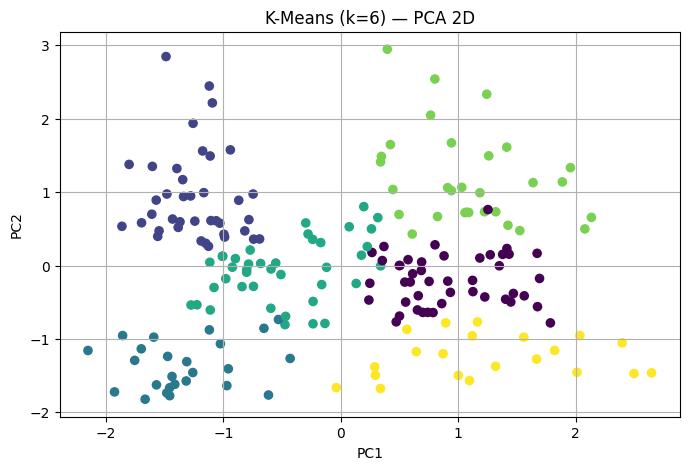

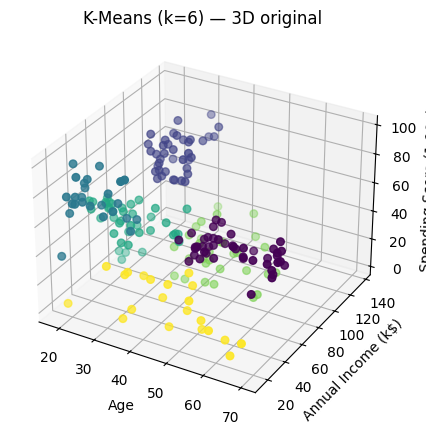

Centroides (en espacio estandarizado):
[[ 1.25472096 -0.24021294 -0.04399777]
 [-0.44191719  0.99158305  1.23950275]
 [-0.95377931 -1.30081415  1.01091344]
 [-0.91323113 -0.0433223  -0.22322397]
 [ 0.36959845  1.12879725 -1.25264236]
 [ 0.47895722 -1.30822992 -1.19644353]]


In [11]:

kmeans = KMeans(n_clusters=mejor_k, random_state=42, n_init="auto").fit(X_scaled)
labels_km = kmeans.labels_
met_km = evaluar(labels_km, X_scaled)

print("📊 Métricas K-Means:", met_km)

# Visualizaciones: PCA 2D y 3D con variables originales
plot2d(X_2d, labels_km, f"K-Means (k={mejor_k}) — PCA 2D")
plot3d(X.values, labels_km, f"K-Means (k={mejor_k}) — 3D original", FEATURES)

# (Opcional informativo) centroides en espacio estandarizado:
print("Centroides (en espacio estandarizado):")
print(kmeans.cluster_centers_)



**Interpretación — K-Means:**  
- Silhouette alto ⇒ grupos compactos y separados.  
- El codo refuerza puntos de saturación en inercia.  
- En negocio, cada cluster puede representar segmentos por edad/ingreso/gasto.



## 8) Modelo 2 — DBSCAN
**Idea:** arma grupos si hay **densidad suficiente**; puntos aislados son **ruido** (-1).  
**Ventajas:** no requiere *k*, detecta **formas arbitrarias**, maneja **outliers**.  
**Sensibilidad:** a `eps` (radio) y `min_samples` (vecinos).


### 8.1 k-distance plot (sugerencia de eps)

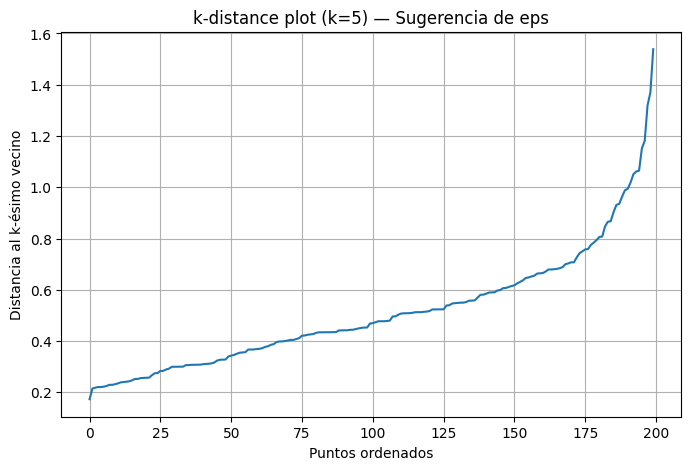

In [12]:

from sklearn.neighbors import NearestNeighbors

k_for_eps = 5  # relacionado a min_samples
nbrs = NearestNeighbors(n_neighbors=k_for_eps).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

# Distancia al k-ésimo vecino ordenada: 'codo' sugiere eps
k_dists = np.sort(distances[:, -1])
plt.figure()
plt.plot(k_dists)
plt.title(f"k-distance plot (k={k_for_eps}) — Sugerencia de eps")
plt.xlabel("Puntos ordenados"); plt.ylabel("Distancia al k-ésimo vecino")
plt.show()


### 8.2 Búsqueda de parámetros y evaluación

⚙️ Mejor DBSCAN: {'eps': 0.49, 'min_samples': 4} | Ruido: 39
📊 Métricas DBSCAN: {'silhouette': np.float64(0.2419582026379482), 'dbi': np.float64(1.767719674876394), 'chi': np.float64(31.132182473867893), 'n_clusters': 10}


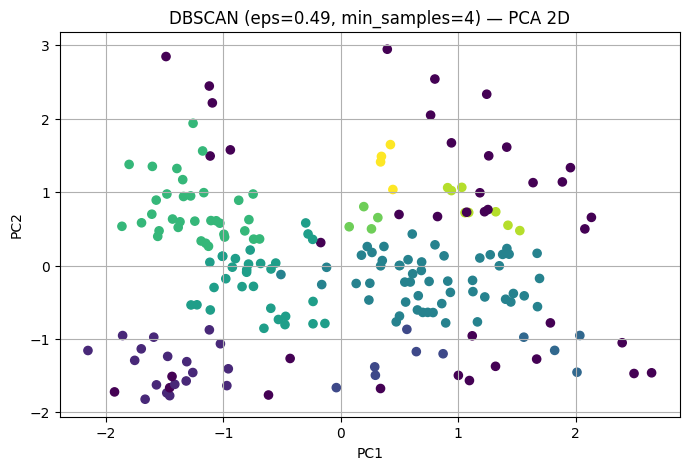

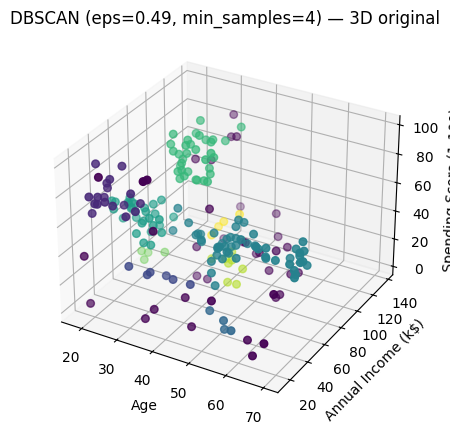

In [13]:

from sklearn.cluster import DBSCAN

eps_list = np.linspace(0.2, 3.0, 20)
min_samples_list = [3, 4, 5, 6, 8, 10]

mejor_conf_db, mejor_sil_db = None, -1
mejor_labels_db = None

for eps in eps_list:
    for ms in min_samples_list:
        model = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = model.labels_
        # clusters válidos (sin contar ruido)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters < 2:
            continue
        met = evaluar(labels, X_scaled)
        if not np.isnan(met['silhouette']) and met['silhouette'] > mejor_sil_db:
            mejor_sil_db = met['silhouette']
            mejor_conf_db = {'eps': float(round(eps,2)), 'min_samples': int(ms)}
            mejor_labels_db = labels

if mejor_labels_db is None:
    # Fallback estable si no se encontró configuración con >=2 clusters válidos
    model = DBSCAN(eps=1.0, min_samples=5).fit(X_scaled)
    mejor_labels_db = model.labels_
    mejor_conf_db = {'eps': 1.0, 'min_samples': 5}

met_db = evaluar(mejor_labels_db, X_scaled)
ruido_db = int(np.sum(np.array(mejor_labels_db) == -1))

print("⚙️ Mejor DBSCAN:", mejor_conf_db, "| Ruido:", ruido_db)
print("📊 Métricas DBSCAN:", met_db)

plot2d(X_2d, mejor_labels_db, f"DBSCAN (eps={mejor_conf_db['eps']}, min_samples={mejor_conf_db['min_samples']}) — PCA 2D")
plot3d(X.values, mejor_labels_db, f"DBSCAN (eps={mejor_conf_db['eps']}, min_samples={mejor_conf_db['min_samples']}) — 3D original", FEATURES)



**Interpretación — DBSCAN:**  
- Útil si hay clusters **no esféricos** y **outliers**.  
- Si hay mucho **ruido** (etiqueta -1), revisar `eps/min_samples`.  
- Si los clusters reales son densos y bien separados, DBSCAN brillará.



## 9) Modelo 3 — Agglomerative (Jerárquico) con Dendrograma
**Idea:** inicia con puntos individuales y **fusiona** clusters (jerarquía).  
**Parámetros:** `linkage` (ward/complete/average) y `k` (número final).

A diferencia de K-Means, genera una **estructura jerárquica** visualizable con **dendrograma** (ayuda a decidir *k*).


### 9.1 Búsqueda de `linkage` y `k` por Silhouette

⚙️ Mejor Agglomerative: {'linkage': 'ward', 'k': 6}
📊 Métricas Agglomerative: {'silhouette': np.float64(0.4201169558789579), 'dbi': np.float64(0.8521020845733146), 'chi': np.float64(127.98645433956887), 'n_clusters': 6}


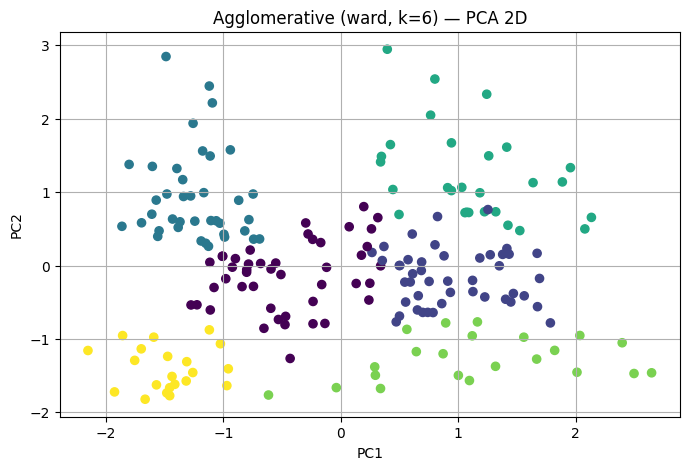

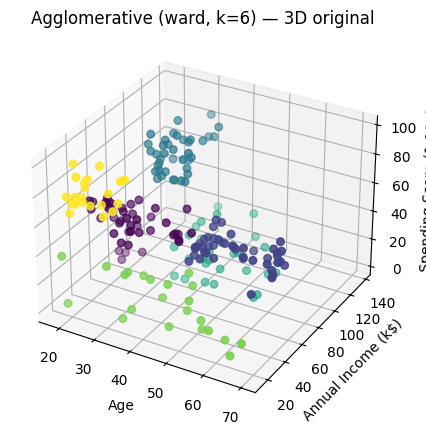

In [14]:

from sklearn.cluster import AgglomerativeClustering

ligaduras = ['ward', 'complete', 'average']
mejor_cfg_ag, mejor_sil_ag = None, -1
mejor_labels_ag = None

for link in ligaduras:
    for k in range(2, 11):
        if link == 'ward':
            ag = AgglomerativeClustering(n_clusters=k, linkage='ward')
        else:
            ag = AgglomerativeClustering(n_clusters=k, linkage=link)
        labels = ag.fit_predict(X_scaled)
        met = evaluar(labels, X_scaled)
        if not np.isnan(met['silhouette']) and met['silhouette'] > mejor_sil_ag:
            mejor_sil_ag = met['silhouette']
            mejor_cfg_ag = {'linkage': link, 'k': int(k)}
            mejor_labels_ag = labels

print("⚙️ Mejor Agglomerative:", mejor_cfg_ag)
met_ag = evaluar(mejor_labels_ag, X_scaled)
print("📊 Métricas Agglomerative:", met_ag)

plot2d(X_2d, mejor_labels_ag, f"Agglomerative ({mejor_cfg_ag['linkage']}, k={mejor_cfg_ag['k']}) — PCA 2D")
plot3d(X.values, mejor_labels_ag, f"Agglomerative ({mejor_cfg_ag['linkage']}, k={mejor_cfg_ag['k']}) — 3D original", FEATURES)


### 9.2 Dendrograma (linkage='ward')

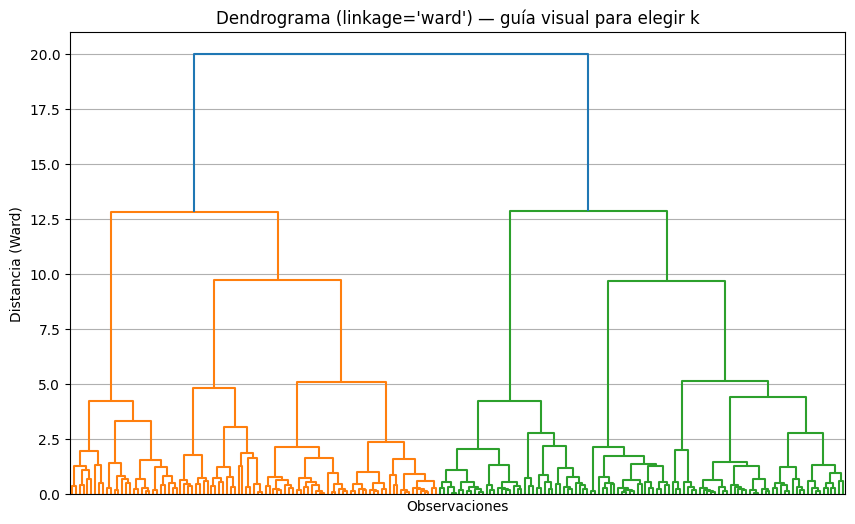

In [15]:

# El dendrograma se construye con SciPy sobre la matriz estandarizada.
from scipy.cluster.hierarchy import linkage, dendrogram

# Calculamos la jerarquía con método 'ward' (minimiza varianza intra-cluster).
Z = linkage(X_scaled, method='ward')

# Dendrograma completo (puede ser largo; si se desea, usar 'truncate_mode' para simplificar)
plt.figure(figsize=(10, 6))
dendrogram(Z, no_labels=True, color_threshold=None)
plt.title("Dendrograma (linkage='ward') — guía visual para elegir k")
plt.xlabel("Observaciones"); plt.ylabel("Distancia (Ward)")
plt.show()

# (Opcional) Corte visual: si se quisiera sugerir un k, se pueden observar 'saltos' grandes en distancias.



**Interpretación — Jerárquico:**  
- El **dendrograma** muestra cómo se fusionan los clusters al aumentar la distancia.  
- Elegir *k* ≈ cortar el dendrograma horizontalmente donde se observe un **salto** grande.



## 10) Comparativa Formal y Diferencias Clave
- **K-Means:** rápido, requiere *k*, asume clusters **aprox. esféricos**, sensible a outliers.  
- **DBSCAN:** no requiere *k*, detecta **formas arbitrarias** y separa **ruido**; elegir `eps` es crítico.  
- **Jerárquico:** ofrece **jerarquía** y **dendrograma**; `linkage` determina el criterio de fusión.

**Métricas a comparar:**  
- **Silhouette (↑)**, **Davies–Bouldin (↓)**, **Calinski–Harabasz (↑)**


In [16]:

import pandas as pd

def fila(nombre, params, metrics):
    return {
        'modelo': nombre,
        'parametros': str(params),
        'clusters': metrics['n_clusters'],
        'silhouette↑': None if np.isnan(metrics['silhouette']) else round(metrics['silhouette'],3),
        'davies-bouldin↓': None if np.isnan(metrics['dbi']) else round(metrics['dbi'],3),
        'calinski-harabasz↑': None if np.isnan(metrics['chi']) else int(metrics['chi'])
    }

resultados = {
    'KMeans':        {'params': {'k': int(globals().get('mejor_k', 0))},                    'metrics': met_km},
    'DBSCAN':        {'params': {**(globals().get('mejor_conf_db', {})), 'noise': int(globals().get('ruido_db', 0))}, 'metrics': met_db},
    'Agglomerative': {'params': globals().get('mejor_cfg_ag', {}),                         'metrics': met_ag}
}

tabla = pd.DataFrame([fila(k, v['params'], v['metrics']) for k, v in resultados.items()]).sort_values(by=['silhouette↑'], ascending=False)
print("=== COMPARATIVO DE MODELOS ===")
display(tabla)


=== COMPARATIVO DE MODELOS ===


,modelo,parametros,clusters,silhouette↑,davies-bouldin↓,calinski-harabasz↑
0,KMeans,{'k': 6},6,0.431,0.835,134
2,Agglomerative,"{'linkage': 'ward', 'k': 6}",6,0.420,0.852,127
1,DBSCAN,"{'eps': 0.49, 'min_samples': 4, 'noise': 39}",10,0.242,1.768,31



## 11) Conclusión y Recomendación
1. **Mejor desempeño**: seleccionar el modelo con **Silhouette** más alto y **DBI** más bajo (y buen **CHI**).  
2. **Interpretabilidad**: elegir el que muestre segmentos comprensibles (edad/ingreso/gasto).  
3. **Recomendación**: si la estructura es **esférica** y estable, **K-Means** o **Ward** suelen ir bien; si hay **formas irregulares** y **outliers**, considerar **DBSCAN**.

> Siguiente paso en negocio: **perfilar** cada cluster (medianas/medias por variable) y **proponer acciones** (promos, fidelización, pricing).



## 12) Limitaciones, Riesgos y Mejoras
- Usar sólo **3 variables** simplifica, pero puede omitir factores (frecuencia, género, canal, ticket).  
- Sensible a **escala** y **métrica de distancia**.  
- K-Means depende de *k* y centroides iniciales; DBSCAN de `eps/min_samples`.  
- **Mejoras**: añadir variables relevantes, validar con **bootstrap**, probar **GMM** y **HDBSCAN**, usar **silhouette per cluster** y análisis de estabilidad.



## 13) Exportación de Etiquetas (para perfilar segmentos)
Se exportan las etiquetas de los 3 modelos para que puedan cruzarse con el dataset original y generar **perfiles** de cada cluster.


In [17]:

out = pd.DataFrame({'fila': idx_valid})
out['KM_labels'] = globals().get('labels_km')
out['DB_labels'] = globals().get('mejor_labels_db')
out['AG_labels'] = globals().get('mejor_labels_ag')
out.to_csv("clusters_resultados_mall.csv", index=False)
print("💾 Archivo 'clusters_resultados_mall.csv' guardado.")
display(out.head())


💾 Archivo 'clusters_resultados_mall.csv' guardado.


,fila,KM_labels,DB_labels,AG_labels
0,0,2,-1,4
1,1,2,0,5
2,2,5,-1,4
3,3,2,0,5
4,4,5,1,4
